<a href="https://colab.research.google.com/github/WhiteHum/Medical-AI-Deep-Learning-Drug-Toxicitiy-Prediction-/blob/main/07_Histology_Image_weakly_supervised_Learning_Segmentation_TCGA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 구글 드라이브 마운트

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **데이터 준비 및 전처리**

###**필요한 데이터 다운 받기 GDC-client로 TCGA slide image 다운받기** 

In [2]:
!unzip /content/drive/MyDrive/패스트캠퍼스/Part2/Part_2/실습/07.Histology_Image_weakly_supervised_Learning_segmentation/gdc-client_v1.6.1_Ubuntu_x64.zip

Archive:  /content/drive/MyDrive/패스트캠퍼스/Part2/Part_2/실습/07.Histology_Image_weakly_supervised_Learning_segmentation/gdc-client_v1.6.1_Ubuntu_x64.zip
 extracting: gdc-client              


In [3]:
!./gdc-client download -m /content/drive/MyDrive/패스트캠퍼스/Part2/Part_2/실습/07.Histology_Image_weakly_supervised_Learning_segmentation/gdc_manifest_20220410_013342.txt

100% [#############################################] Time:  0:00:32   3.4 MiB/s 
Successfully downloaded: 1


### **필요한 라이브러리 준비**

In [4]:
!unzip /content/drive/MyDrive/패스트캠퍼스/Part2/Part_2/실습/07.Histology_Image_weakly_supervised_Learning_segmentation/pytorch_grad_cam.zip

# Install ttach(Image Test Time Augmentation with PyTorch)
!pip install ttach

# Install python-openslide
!apt update && apt install -y openslide-tools
!pip install openslide-python

Archive:  /content/drive/MyDrive/패스트캠퍼스/Part2/Part_2/실습/07.Histology_Image_weakly_supervised_Learning_segmentation/pytorch_grad_cam.zip
   creating: pytorch_grad_cam/
  inflating: __MACOSX/._pytorch_grad_cam  
  inflating: pytorch_grad_cam/grad_cam_plusplus.py  
  inflating: __MACOSX/pytorch_grad_cam/._grad_cam_plusplus.py  
  inflating: pytorch_grad_cam/guided_backprop.py  
  inflating: pytorch_grad_cam/.DS_Store  
  inflating: __MACOSX/pytorch_grad_cam/._.DS_Store  
  inflating: pytorch_grad_cam/eigen_grad_cam.py  
  inflating: pytorch_grad_cam/fullgrad_cam.py  
  inflating: pytorch_grad_cam/activations_and_gradients.py  
  inflating: __MACOSX/pytorch_grad_cam/._activations_and_gradients.py  
  inflating: pytorch_grad_cam/__init__.py  
  inflating: __MACOSX/pytorch_grad_cam/.___init__.py  
  inflating: pytorch_grad_cam/xgrad_cam.py  
   creating: pytorch_grad_cam/utils/
  inflating: pytorch_grad_cam/grad_cam.py  
   creating: pytorch_grad_cam/__pycache__/
  inflating: pyto

# **데이터 전처리 (data pre-processing)**

### **openslide 이용하여 WSI 다루기**

In [5]:
from PIL import Image
import openslide
import numpy as np

In [6]:
# openslide로 whole slide image(WSI) 불러오기
# TCGA-COAD
slide_mask = openslide.open_slide('/content/ed500fa9-70b1-4d52-9e73-d8d512448901/TCGA-AD-6901-01Z-00-DX1.0a69c0b5-6238-4c1a-bbbd-ea743bf6fc98.svs')

top_left = (6000, 6000) #$ top left 픽셀 값
level_dim = slide_mask.level_dimensions # WSI levels
for i, dim in enumerate(level_dim):
  print(f'Level{i} 픽셀 크기 : {dim}')

vis_level = 0 
region_size = level_dim[vis_level] # 해당 level에서 전체 픽셀 크기

Level0 픽셀 크기 : (35492, 32395)
Level1 픽셀 크기 : (8873, 8098)
Level2 픽셀 크기 : (2218, 2024)


### **Magnification 바꾸기**

In [7]:
# 자를 이미지 크기
crop_size = (224 * 3, 224*3)

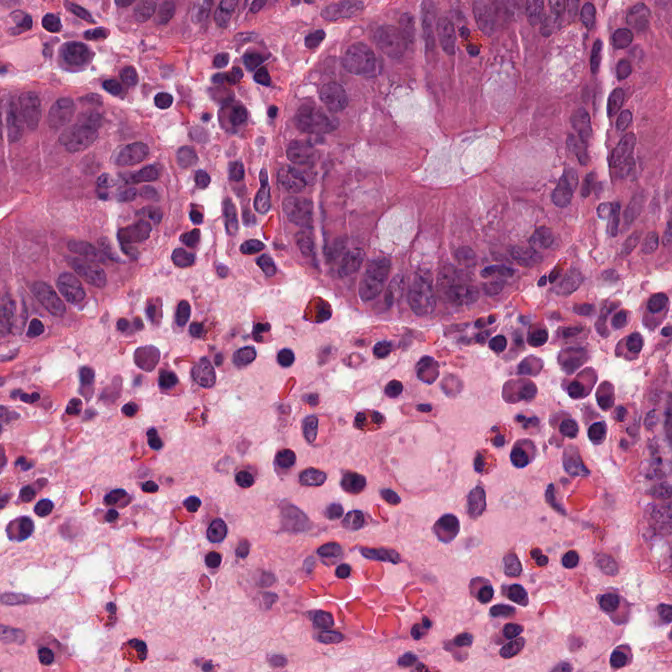

In [8]:
# vis_level 0 = (20x magnification)
slide_mask.read_region(top_left, 0, crop_size).convert('RGB')

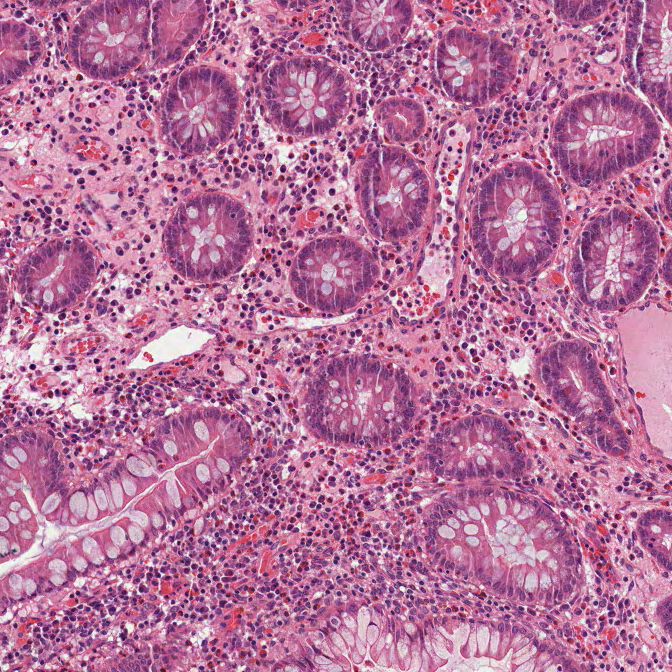

In [9]:
# vis_level 1 = (10x magnification)
slide_mask.read_region(top_left, 1, crop_size)

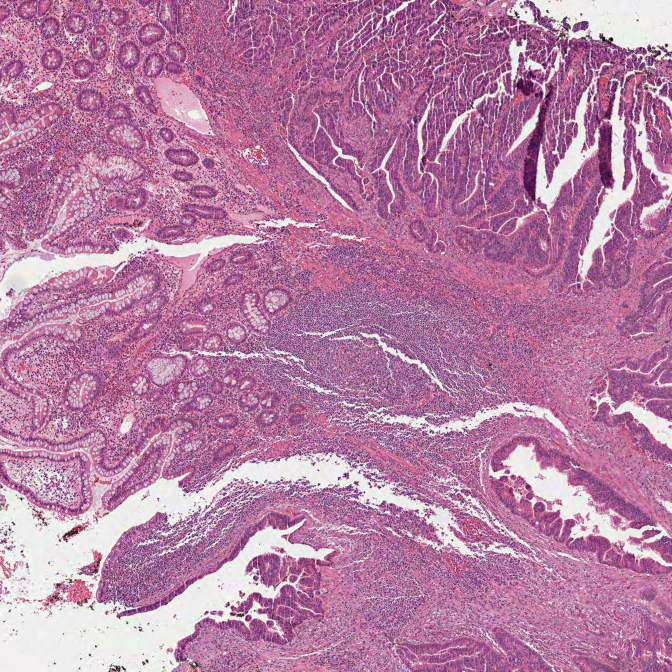

In [10]:
# vis_level 2 = (5x magnification)
slide_mask.read_region(top_left, 2, crop_size)

### **테스트 진행을 위한 전처리**

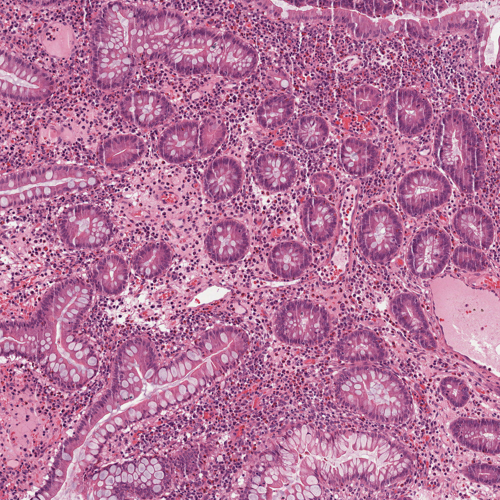

In [11]:
# WSI 자르기

top_left = (5000, 5000)
crop_size = (224* 18, 224*18)

# WSI 이미지 잘라서 가져오기
test_im2arr = np.array(slide_mask.read_region(top_left, 0, crop_size).convert('RGB'))
Image.fromarray(test_im2arr).resize((500,500))

**Whole Slide image (WSI) 패치 이미지로 나누기**

In [12]:
slide_x_size = test_im2arr.shape[1] # WSI의 열 차원 크기
slide_y_size = test_im2arr.shape[0] # WSI의 행 차원 크기

# 추출할 패치 사이즈
step_x = 224 # X축 (열방향) 사이즈
step_y = 224 # Y축 (행방향) 사이즈

# 각 축 별 추출할 패치 개수
num_x = int(slide_x_size/step_x) # X측 방향 개수
num_y = int(slide_y_size/step_y) # Y축 방향 개수
print(f'총 패치 데이터의 개수 : {num_x*num_y}')

# WSI를 패치로 나누어 리스트에 저장
image_split_list = []

for y_index in range(0, num_y):
  for x_index in range(0, num_y):
    temp_image = test_im2arr[step_y * y_index : step_y * (y_index +1), step_x * x_index : step_x * (x_index +1)]
    image_split_list.append(temp_image)

총 패치 데이터의 개수 : 324


**테스트 세팅**

In [13]:
# 필요한 라이브러리 불러오기
from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
from torchvision.models import resnet50
import torch.nn as nn
from pytorch_grad_cam import GradCAM

In [14]:
# 디바이스 설정
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'현재 디바이스는 {device}입니다.')

현재 디바이스는 cuda:0입니다.


In [15]:
# data transform 적용하기

image_transforms = { 
    'train': transforms.Compose([
        # transforms.Resize(size=224),
        transforms.ToTensor(),

        # data augmentation
        transforms.RandomRotation(90, expand=False),
        transforms.RandomRotation(180, expand=False),
        transforms.RandomRotation(270, expand=False),
        
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        # transforms.Resize(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [16]:
# Dataset 클래스 직접 정의하기

# 슬라이드 패치 이미지를 위한 추상 클래스
# torch.utils.data.Dataset을 상속 받아 오버라이드
class Image_Array_list_test_Dataset(Dataset):
  
  # data : 추출한 패치들이 담긴 리스트
  # transform : 데이터에 적용될 transform (optinal)
  def __init__(self, data, transform=None):
    self.data = data
    self.transform= transform

  def __len__ (self):
    return len(self.data)
  
  def __getitem__(self, index):
    x = self.data[index]

    if self.transform:
      x = Image.fromarray(self.data[index].astype(np.uint8))
      x = self.transform(x)
    return x



In [17]:
# 패치 데이터 데이터셋 인스턴스 생성
test_Dataset = Image_Array_list_test_Dataset(image_split_list, transform = image_transforms['valid'])

# 데이터 로더 적용
test_dataloader = DataLoader(test_Dataset, batch_size=32)

# 데이터 확인해보기
print(f'이미지 shpae = {list(test_Dataset[0].shape)}')

print(f'이미지 크기 = {len(test_Dataset)}')

이미지 shpae = [3, 224, 224]
이미지 크기 = 324


In [18]:
# 데이터 레이블 
Classes = ['ADI', 'BAC', 'LYM', 'MUC', 'MUS', 'NOR', 'STR', 'TUM']

num_classes = len(Classes)

### **미리 학습한 모델 가져오기**

In [19]:
# resnet50 모델 가져오기
model = resnet50(pretrained=False)

# 마지막  layer 변경 (2048 - > 1000 => 2048 -> 128 -> num_classes)
model.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(inplace = True),
    nn.Linear(128, num_classes))

# model device 에 올리기
model = model.to(device)

# 미리학습
model.load_state_dict(torch.load('/content/drive/MyDrive/패스트캠퍼스/Part2/Part_2/실습/07.Histology_Image_weakly_supervised_Learning_segmentation/model.pt'))

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [20]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# **학습한 모델로 Label 없이 image segmenation 하기**

### **이미지 오버레이(overlay) 세팅**

In [21]:
import numpy as np
# 데이터 레이블 
Classes = ['ADI', 'BAC', 'LYM', 'MUC', 'MUS', 'NOR', 'STR', 'TUM']

num_classes = len(Classes)

In [22]:
# 픽셀 색 보여주기
def plot_pixel_color(mask_color):
  
  # from skimage import io
  import matplotlib.pyplot as plt

  num = mask_color.shape[0]
  ind = np.arange(num).reshape(1, num)
  fig = plt.figure(figsize = (num, 2))
  ax = fig.add_subplot(111)
  ax.imshow(mask_color[ind])
  ax.set_yticks([])
  ax.set_xticks(range(num))
  ax.set_xticklabels(Classes)

  plt.show()


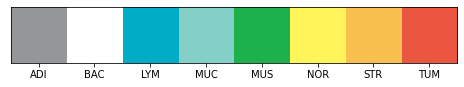

In [23]:
# 각 클래스 별로 masking할 색 정하기

image_mask_color =  np.array([
    [148, 150, 151],  # ADI
    [255, 255, 255],  # BAC
    # [187, 128, 183], 
    [0,   172, 198],  # LYM
    [132, 207, 199], # MUC
    [29,  177,  76], # MUS
    [255, 244,  89], # NOR
    [247, 192,  79], # STR
    [235,  86,  64]   # TUM
])

image_mask_color = image_mask_color / 255


plot_pixel_color(image_mask_color)

In [24]:
# 픽셀별로 mask 적용하기

def apply_mask_image(image, color, alpha = 0.5):

  # image : 각 픽셀값
  # color : 클래스 별 masking color 값을 행으로 하는 행렬 (8x3)
  # alpha : 투명도 [0,1]
  # Return :  image에 mask를 입힌 이미지 반환함

  new_image = (1 - alpha) * image + alpha * image_mask_color[color] * 255
  return new_image

In [25]:
# masking 한 패치 이미지를 다시 전체 슬라이드 이미지로 합치기

def image_crop_list_to_total_image(image_array_list, step_y, step_x, step_num_y, step_num_x):

  # image_array_list : 
  # step_y : 패치 이미지  Y축 사이즈
  # step_x : 패치 이미지  X축 사이즈
  # step_num_y : Y축 방향 패치 이미지 개수
  # step_num_x : X축 방향 패치 이미지 개수
  
  # Return : 합쳐진 전체 슬라이드 이미지

  if len(image_array_list) != step_num_y * step_num_x :
     raise Exception('length of image_Array_list is not same to step_num_y X step_num_x')

  # 전체 슬라이드 이미지와 같은 크기의 영행렬 생성
  out_image_array = np.zeros((step_y * step_num_y, step_x * step_num_x, 3), dtype= np.uint8)

  # masking 된 패치 이미지로 이루어진 전체 슬라이드 이미지 생성
  cnt = 0
  for y_index in range(0, step_num_y):
    for x_index in range(0, step_num_x):
        out_image_array[step_y * y_index : step_y * (y_index +1), step_x * x_index : step_x * (x_index + 1)] = image_array_list[cnt]
        cnt += 1

  return out_image_array


### **패치 별 (segmentation)**

In [26]:
label_list = []

# 학습한 모델을 이용해  inference

for inputs in tqdm(test_dataloader):

  inputs = inputs.to(device, non_blocking=True) 
  outputs = model(inputs)
  outputs = outputs.cpu().detach().numpy()
  label_list.extend(np.argmax(outputs, 1).tolist())

out_result_image_list = []
for index, seg_label_image in enumerate(tqdm(label_list)):
  new_image = apply_mask_image(image_split_list[index], label_list[index])
  out_result_image_list.append(new_image)

100%|██████████| 324/324 [00:00<00:00, 723.58it/s]


In [27]:
# 패치 이미지 하나로 병합
merge_image = image_crop_list_to_total_image(out_result_image_list, step_x, step_y, num_y, num_x)
test_merge_image = Image.fromarray(merge_image)

# 시각화를 위해 사이즈 줄이기
test_merge_image = test_merge_image.resize((int(test_merge_image.width /6), int(test_merge_image.height/6)))

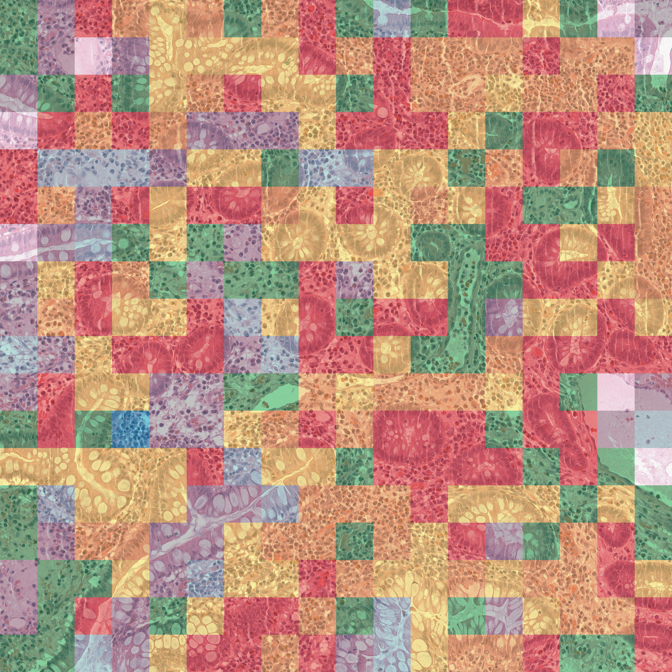

In [28]:
test_merge_image

# **픽션 별 segmentation**

### **GradCAM으로 pixel 별 class 할당**

In [29]:
# # model 마지막 층 가져오기
# target_layers = [model.layer4[-1]]

# cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)

# model 마지막 층 가져오기
target_layers = [model.layer4[-1]]

cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)

In [30]:
cnt = 0

for inputs in tqdm(test_dataloader):
    
    gradcam_8_class_pred_weight_all_class_batch = np.zeros((8, inputs.shape[0], inputs.shape[2], inputs.shape[3])) # [8 x batch_size x 224 x 224]

    inputs = inputs.to(device) # [batch_size, 3, 224, 224]
    outputs = model(inputs) # [batch_size x num_classes(8)]
    
    for i in range(num_classes):
        gradcam_8_class_pred_weight_one_class_batch = np.zeros((inputs.shape[0], inputs.shape[2], inputs.shape[3])) # [batch_size x 224 x 224]
        
        class_score = outputs[:, i].cpu().detach().numpy() # [batch_size]
        
        grayscale_cam = cam(input_tensor=inputs, target_category=i) # GradCAM 적용 [batch_size x 224 x 224]
        
        for batch_index, score in enumerate(class_score):
            gradcam_8_class_pred_weight_one_class_batch[batch_index, : , :] = grayscale_cam[batch_index, :, :] * score # cam output x classification score
        
        
        gradcam_8_class_pred_weight_all_class_batch[i, :, : , :] = gradcam_8_class_pred_weight_one_class_batch

        gradcam_8_class_pred_weight_all_class_batch = np.float16(gradcam_8_class_pred_weight_all_class_batch)

    if cnt == 0:
        all_gradcam = gradcam_8_class_pred_weight_all_class_batch
    
    else:
        all_gradcam = np.concatenate((all_gradcam, gradcam_8_class_pred_weight_all_class_batch), axis=1) 
    
    # all_gradcam: [num_classes(8), num_patches(900), 224, 224]

    cnt += 1
    
  

100%|██████████| 11/11 [00:25<00:00,  2.29s/it]


In [31]:
# class 차원에 대해  argmax
argmax_result_matrix = np.argmax(all_gradcam, axis=0)


In [32]:
# class 별 개수 구하기
unique, counts = np.unique(argmax_result_matrix, return_counts = True)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Counts')

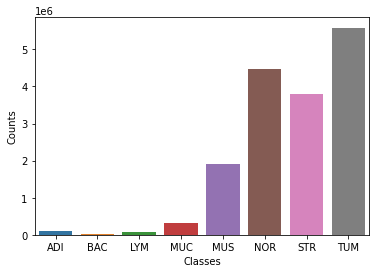

In [33]:
# 픽셀 별 class 분포

import seaborn as sns
import matplotlib.pyplot as plt

ax = plt.subplot()
sns.barplot(unique, counts)
ax.set_xticks(unique)
ax.set_xticklabels(Classes)
plt.xlabel('Classes')
plt.ylabel('Counts')

In [34]:
component_rate = dict(zip(Classes, counts))

# TSR 확인
component_rate['STR'] / (component_rate['STR']+component_rate['TUM'])

0.40510843684649483

### **픽셀 별로 masking 하기**

In [35]:
# 패치 이미지의 모든 픽셀마다 미리 지정한 클래스 별 색으로 masking 하기
def apply_mask_pixel_for_multi_processing(argmax_result_matrix, original_image_matrix):

  if isinstance(original_image_matrix, list):
    if len(argmax_result_matrix) != len(original_image_matrix):
      raise Exception('original imqge와 argmax result의 크기가 다릅니다.')

    out_result_image_list = []
    
    for index, seg_label_image in enumerate(tqdm(argmax_result_matrix)):
      new_image = np.zeros((224,224,3))
      
      for width in range(224):
          for height in range(224):
              new_image[width, height] = apply_mask_image(original_image_matrix[index][width, height], seg_label_image[width, height])

      out_result_image_list.append(new_image)
    return out_result_image_list
  elif isinstance(original_image_matrix, np.ndarray):
      if original_image_matrix.shape[:2] != argmax_result_matrix.shape:
          raise Exception('original image와  argmax result의 shape를 확인해 주세요.')

      dim_y = original_image_matrix.shape[0]
      dim_x = original_image_matrix.shape[1]

      new_image = np.zeros((dim_y, dim_x, 3))

      for width in range(dim_y):
          for height in range(dim_x):
              new_image[width, height] = apply_mask_image(original_image_matrix[width, height], argmax_result_matrix[width, height])
      return new_image

  else:
      raise Exception('original_image_matrix의 형이 적절하지 않습니다.')


In [36]:
# 병렬 처리를 위한 라이브러리
import multiprocessing

num_cpu = multiprocessing.cpu_count()
print(f'현재 이용 가능한 CPU의 개수 : {num_cpu}')

현재 이용 가능한 CPU의 개수 : 2


In [37]:
# 지정된 코어 개수 만큼 데이터를 나누어서 병렬 처리 진행 후 결과 병합
def do_multi_n_merge(argmax_result_matrix, original_image_matrix, num_cores):


  # argmax_result_matrix  픽셀 별 class 값을 가지는 매트릭스
  # num_cores : 병렬 처리에 사용할 코어 개수
  # Returns : 병럴 처리한 결과가 담긴 리스트

  # 전체 패치 개수를 코어 개수로 나누기
  step_data = argmax_result_matrix.shape[0] // num_cores

  # 병렬 처리를 위해 리스트에 데이터 나누어 담기
  split_argmax_result_matrix = [] # 픽셀 별 class 값을 나누어 담을 리스트
  split_original_image_matrix = []  # 전체 패치 이미지를 나누어 담을 리스트

  for i in range(0, num_cores):
      if i == num_cores - 1:
          split_argmax_result_matrix.append(argmax_result_matrix[i *  step_data:])
          split_original_image_matrix.append(original_image_matrix[i * step_data:])
      else :
          split_argmax_result_matrix.append(argmax_result_matrix[i * step_data : (i+1) *  step_data:])
          split_original_image_matrix.append(original_image_matrix[i * step_data : (i+1) * step_data:])

  # 병렬 처리 진행
  pool = multiprocessing.Pool(processes = num_cores)
  test = pool.starmap(apply_mask_pixel_for_multi_processing, zip(split_argmax_result_matrix, split_original_image_matrix))

  # 병렬 처리한 결과 병합
  test_merge = []

  for multi_result in test : 
      test_merge.extend(multi_result)

  return test_merge


In [38]:
# test_merge = do_multi_n_merge(argmax_result_matrix, image_split_list, num_cpu)

test_merge = do_multi_n_merge(argmax_result_matrix, image_split_list, num_cpu)

100%|██████████| 162/162 [01:54<00:00,  1.41it/s]


### **Masking 한 패치 이미지 하나로 병합**

In [39]:
# # 패치 이미지 하나로 병합

# merge_image = image_crop_list_to_total_image(test_merge, step_x, step_y, num_y, num_x)
# test_merge_image = Image.fromarray(merge_image)

# # 시각화를 위해 사이즈 줄이기
# test_merge_image = test_merge_image.resize((int(test_merge_image.width / 6), int(test_merge_image.height / 6)))

# 패치 이미지 하나로 병합
merge_image = image_crop_list_to_total_image(test_merge, step_x, step_y, num_y, num_x)
test_merge_image = Image.fromarray(merge_image)

# 시각화를 위해 사이즈 줄이기
test_merge_image = test_merge_image.resize((int(test_merge_image.width / 6), int(test_merge_image.height / 6)))

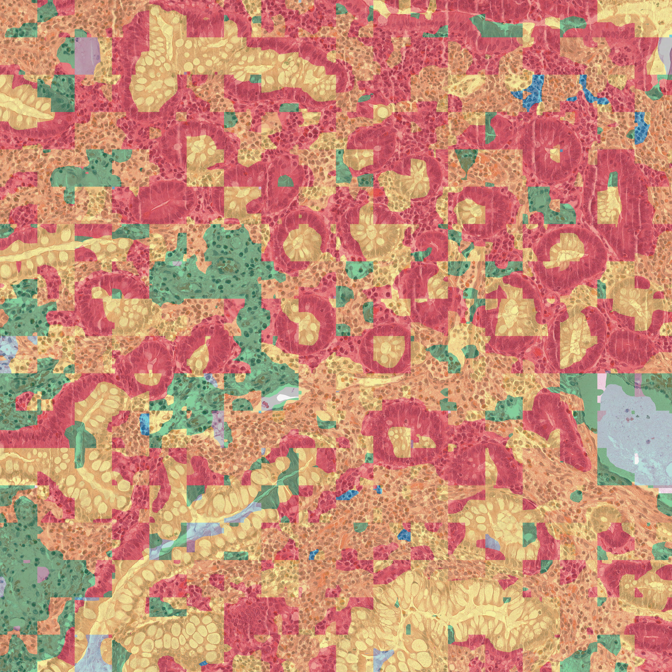

In [40]:
test_merge_image

### **DenseCRF를 이용해 segmentation 정교하게 이용하기**

In [41]:
# pydenserf 설치
# Python wrapper for denseCRFs

!pip install git+https://github.com/lucasb-eyer/pydensecrf.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-c_hkub49
  Running command git clone -q https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-c_hkub49
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pydensecrf: filename=pydensecrf-1.0rc2-cp38-cp38-linux_x86_64.whl size=2845202 sha256=b75bd6d4b96ff0cc3673367187cca9b470c2d9f1af237faa492882c4cd14c3f0
  Stored in directory: /tmp/pip-ephem-wheel-cache-exw3npcl/wheels/45/56/7a/826b4f5cd8459926ff5996ba9994fc36672487b6d2fa50d3d4
Successfully built pydensecrf


In [42]:
# 라이브러리 호출하기

import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax
from scipy.special import softmax

In [43]:
# 앞서 구한 pixel별 scroe에 softmax 적용 (픽셀별로 클래스 확률 값 구하기)
probs = softmax(all_gradcam, axis =0)

In [44]:
temp_array = np.zeros((8, 224* num_y, 224*num_x))
cnt = 0
for y_index in range(num_y):
    for x_index in range(num_x):
        temp_array[:, 224 * y_index : step_y * (y_index +1), 224* x_index : step_x * (x_index + 1)] = probs[:, cnt]
        cnt +=1


In [45]:
temp_array.shape

(8, 4032, 4032)

In [46]:
class DenseCRF:
  def __init__ (self, gauss_sxy=3, gauss_compat = 3, bilat_sxy=80, bilat_srgb=13, bilat_compat=10):
    self.gauss_sxy = gauss_sxy
    self.gauss_compat = gauss_compat
    self.bilat_sxy = bilat_sxy
    self.bilat_srgb = bilat_srgb
    self.bilat_compat = bilat_compat

  def run(self, probs, images):

      num_classes = probs.shape[0]
      size = probs.shape[1:]

      d = dcrf.DenseCRF2D(size[1], size[0], num_classes)
      U = np.ascontiguousarray(unary_from_softmax(probs))
      d.setUnaryEnergy(U)
      d.addPairwiseGaussian(sxy=self.gauss_sxy, compat = self.gauss_compat)
      d.addPairwiseBilateral(sxy=self.bilat_sxy, srgb=self.bilat_srgb, rgbim=np.ascontiguousarray(images), compat = self.bilat_compat)
      Q = d.inference(100)
      crf = np.array(Q).reshape((num_classes, size[0], size[1]))
      maxconf_crf = np.argmax(crf, axis=0)
      return maxconf_crf


In [47]:
densecrf = DenseCRF()
maxconf_crf = densecrf.run(temp_array, test_im2arr)

In [48]:
test_merge = do_multi_n_merge(maxconf_crf, test_im2arr, num_cpu)

In [49]:
test_image_crf = np.array(test_merge, dtype=np.uint8)
test_image_crf = Image.fromarray(test_image_crf)

# 시각화를 위해 사이즈 줄이기
test_image_crf = test_image_crf.resize((int(test_image_crf.width / 6), int(test_image_crf.height / 6)))

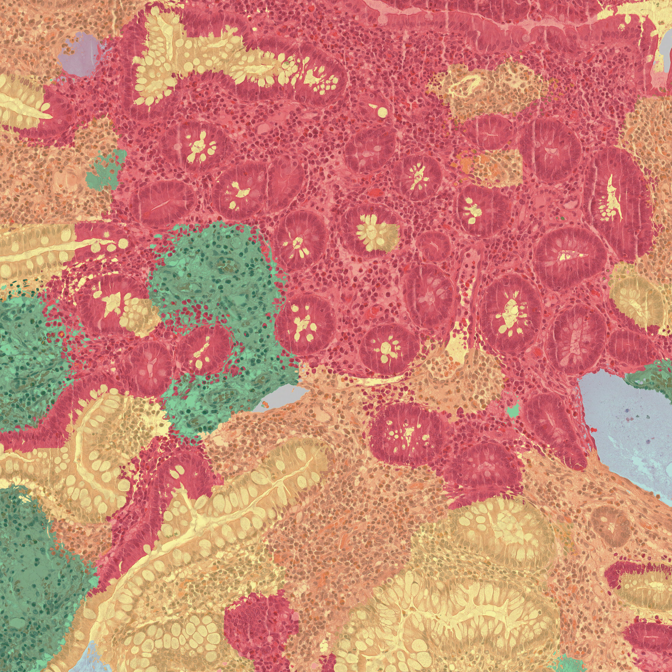

In [50]:
test_image_crf